# Вариационный автокодировщик

В задании предлагается реализовать вариационный и обычный автокодировщики, обучить их на MNIST, сравнить между собой эти модели, сделать выводы по результатам сравнения и выводы про каждую модель по отдельности.

Необходимая теория приведена ниже. Для более глубокого погружения в тему также есть список литературы с комментариями.

В этом задании нельзя использовать функций плотностей распределений и репараметризации из стандартных библиотек.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_vae.ipynb

## Теория

### Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

### Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. Сэмплируем $x \sim p_\theta(x | z)$.

Параметры распределения $p_\theta(x | z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$$

### Параметризация модели
Априорное распределение на скрытые перменные - стандартное нормальное распределение: $p(z) = \mathcal{N}(z | 0, I)$.

Распределения на компоненты $x$ условно независимы относительно $z$: $p_\theta(x | z) = \prod\limits_{i = 1}^D p_\theta(x_i | z)$.

Если i-ый признак объекта вещественный, то $p_\theta(x_i | z) = \mathcal{N}(x_i | \mu_i(z, \theta), \sigma^2_i(z, \theta))$.
Здесь $\mu(z, \theta)$ и $\sigma(z, \theta)$ - детерминированные функции, задаваемые нейросетями с параметрами $\theta$.

Если i-ый признак категориальный, то $p_\theta(x_i | z) = Cat(Softmax(\omega_i(z, \theta)))$, где $\omega_i(z, \theta)$ - тоже детерминированная функция задаваемая нейросетью.

Отдельно можно рассмотреть бинарные признаки, для которых категориальное распределение превращается в распределение Бернулли с одним параметром.

### Вариационная нижняя оценка логарифма правдоподобия

Для максимизации правдоподобия максимизируем вариационную нижнюю оценку на логарифм правдоподобия:
$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x) = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z) q_\phi(z | x)}{q_\phi(z | x) p_\theta(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z)}{q_\phi(z | x)} + KL(q_\phi(z | x) || p_\theta(z | x))$$
$$\log p_\theta(x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - KL(q_\phi(z | x) || p(z)) = L(x; \phi, \theta)
\to \max\limits_{\phi, \theta}$$

$q_\phi(z | x)$ называется предложным (proposal) или распознающим (recognition) распределением. Это гауссиана, чьи параметры задаются нейросетью с весами $\phi$:
$q_\phi(z | x) = \mathcal{N}(z | \mu_\phi(x), \sigma^2_\phi(x)I)$.
Обычно нейросеть моделирует не $\sigma_\phi(x)$, а $\log\sigma_\phi(x)$ или другую величину, более инвариантную к масштабу и определенную на всех вещественных числах так, чтобы $\sigma_\phi(x)$ было всегда положительным.

Зазор между вариационной нижней оценкой $L(x; \phi, \theta)$ на логарифм правдоподобия модели и самим логарифмом правдоподобия $\log p_\theta(x)$ - это KL-дивергенция между предолжным и апостериорным распределением на $z$: $KL(q_\phi(z | x) || p_\theta(z | x))$. Максимальное значение $L(x; \phi, \theta)$ при фиксированных параметрах модели $\theta$ достигается при $q_\phi(z | x) = p_\theta(z | x)$, но явное вычисление $p_\theta(z | x)$ требует слишком большого числа ресурсов, поэтому вместо этого вычисления вариационная нижняя оценка оптимизируется также по $\phi$. Чем ближе $q_\phi(z | x)$ к $p_\theta(z | x)$, тем точнее вариационная нижняя оценка.
Есть статьи, показывающие, что истинное апостериорное распределение $p_\theta(z | x)$ часто не может быть представлено одной гауссианой, поэтому зазор между нижней оценкой и логарифмом правдоподобия не достигает $0$. Тем не менее, этот зазор практически не влияет на процесс оптимизации модели и его результат по сравнению с другими факторами.

Первое слагаемое вариационной нижней оценки $\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z)$ называется ошибкой восстановления (reconstruction loss).
Модель, соответствующая этой части - это автокодирощик с одним стохастическим слоем, пытающийся восстановить входной объект $x$.
Если распределение $q_\phi(z | x)$ - дельта-функция, то автокодировщик со стохастическим слоем превращается в обычный автокодировщик.
Поэтому $q_\phi(z | x)$ и $p_\theta(x | z)$ иногда называют энкодером и декодером соответственно.

Слагаемое $KL(q_\phi(z | x) || p(z))$ иногда называют регуляризатором.
Оно вынуждает $z \sim q_\phi(z | x)$ быть близким к $0$ и $q_\phi(z | x)$ быть близким к $p_\theta(z | x)$.
Иногда коэффициент при KL-дивергенции полагают не равным единице или даже используют другой регуляризатор.
Естественно, после этого обучение модели перестает соответствовать максимизации правдоподобия вышеописанной вероятностной модели данных.
Это существенно снижает интерпретируемость модели, устраняет теоретические гарантии для неё.
KL-дивергенция между двумя нормальными распределениями может быть вычислена аналитически.

Для максимизации $L(x; \phi, \theta)$ используется стохастический градиентный подъем.
Градиент ошибки восстановления по $\theta$ вычисляется с помощью метода обратного распространения ошибки.
$$\frac{\partial}{\partial \theta} L(x; \phi, \theta) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{\partial}{\partial \theta} \log p_\theta(x | z)$$

Градиент KL-дивергенции по $\phi$ может быть вычислен аналитически.
Для вычисления градиента ошибки восстановления по $\phi$ используется репараметризация (reparametrization trick):
$$\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)$$
$$z = \mu + \sigma \varepsilon \Rightarrow z \sim \mathcal{N}(z | \mu, \sigma^2I)$$
$$\frac{\partial}{\partial \phi} L(x; \phi, \theta) = \mathbb{E}_{\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)} \frac{\partial}{\partial \phi} \log p_\theta(x | \mu_\phi(x) + \sigma_\phi(x) \varepsilon) - \frac{\partial}{\partial \phi} KL(q_\phi(z | x) || p(z))$$

### Оценка правдоподобия модели

Правдоподобие модели $p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$ оценивают на отложенной выборке.

Оценка может быть получена с помощью метода Монте-Карло:

$$z_i \sim p(z), i = 1, \dots, K$$
$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i)$$

Альтернативный способ оценки - метод importance sampling. В качестве предложного распределения метода используется предложное распределение модели. Известно, что хороший выбор предложного распределения уменьшает дисперсию оценки. В случае вариационного автокодировщика оценки Монте-Карло, основанные на малом числе сэмплов, обычно занижены, поэтому imporatance sampling также позволяет получить более высокую и точную оценку правдоподобия с помощью меньшего числа сэмплов.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}$$

Для оценки логарифма правдоподобия усреднение вероятностей происходит под логарифмом:
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i),\,\,\,\,z_i \sim p(z)$$
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x)$$

### Литература
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf - оригинальная статья про вариационный автокодировщик.
2. Learning Structured Output Representation using Deep Conditional Generative Models https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf - обусловленный вариационный автокодировщик для генерации из обусловленного распределения.
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf - вариационный автокодировщик с более точной вариационной нижней оценкой.
4. Ladder Variation Autoencoders http://papers.nips.cc/paper/6275-ladder-variational-autoencoders.pdf - теперь у каждого объекта есть не одно скрытое представление, а много.
5. Variational Inference with Normalizing Flows https://arxiv.org/pdf/1505.05770.pdf, Improved Variational Inference with Inverse Autoregressive Flow http://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow.pdf - более богатые семейства предложных распредлений.

## Практика

### Загрузка, предобработка и визуалиация данных

In [1]:
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import numpy as np

In [22]:
# from torchvision import transforms
# author_transformation = transforms.Compose([
#   transforms.ToTensor(),
#   #nn.AvgPool2d(2,2),
# ])

# mnist_dataset = MNIST('mnist', download=True, transform=author_transformation)

# val_amount = 5000
# test_amount = 10000
# train_amount = 45000

# train_data, test_data, val_data = torch.utils.data.dataset.random_split(mnist_dataset.train_data.view(-1, 28 * 28).float() / 255, [train_amount, test_amount, val_amount])

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)


In [87]:
# from torchvision import transforms
# author_transformation = transforms.Compose([
#   transforms.ToTensor(),
#   transforms.Lambda(lambda image: image.round()) # returns a 4D tensor
# ])

data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset((data.train_data.view(-1, 28 * 28).float() / 255) .round(), data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset((data.test_data.view(-1, 28 * 28).float() / 255) .round(), data.test_labels)

Для корректности вероятностной модели исходное изображение также должно быть бинаризовано.

Бинаризация может производиться как округлением данных в датасете, так и сэмплированием из распределения Бернулли каждого пикселя. Округление приводит к более гладким фигурам в обучающей выборке, поэтому будем использовать его.

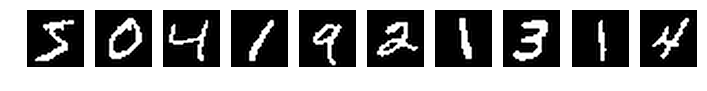

In [88]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

### Вспомогательные функции для обучения и тестирования

In [89]:
def model_test_loss(compute_loss, batch_size=100, max_batches=None, verbose=False):
    """
    Функция вычисляет усредненное значение функции потерь по тестовым данным.
    Вход: compute_loss, функция, принимающая батч в виде матрицы torch.FloatTensor
    и возвращающая float - функцию потерь на батче.
    Вход: batch_size, int.
    Вход: max_batches, int - если задано, включает режим оценки функции потерь
    с помощью сэмплирования батчей вместо полного прохода по данным и указывает,
    после какого батча прекратить вычисления.
    Вход: verbose, bool - указывает, печатать ли текущее состояние в процессе работы.
    Возвращаемое значение: float - оценка функции потерь на тестовых данных.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=(max_batches is None))
    num_batches = len(dataloader)
    avg_loss = 0
    for i, (batch, _) in enumerate(dataloader):
        loss = compute_loss(batch)
        avg_loss += (loss - avg_loss) / (i + 1)
        if verbose and (i + 1) % 10 == 0:
            print('\rTest loss:', avg_loss,
                  'Batch', i + 1, 'of', num_batches, ' ' * 10, end='', flush=True)
        if verbose and (i + 1) % 100 == 0:
            print(flush=True)
        if max_batches and i >= max_batches:
            break
    return avg_loss

In [90]:
def train_model(model, tests=[], batch_size=100, num_epochs=5, learning_rate=1e-3, maximization=True):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss = model.batch_loss(batch)
            train_losses.append(loss.data.item())
            if maximization:
                (-loss).backward()
            else:
                loss.backward()
            
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

In [91]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

In [92]:
def draw_latent_space(data, target, encoder):
    z_test = encoder(data).data.numpy()
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

In [93]:
from sklearn.manifold import TSNE
import torch.nn.functional as F

## Обычный автокодировщик

In [94]:
class AE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.encoder = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.d)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        )
        # glorot uniform initialization
        lin_layers = []
        lin_layers += [layer for layer in self.encoder if isinstance(layer, nn.Linear)]
        lin_layers += [layer for layer in self.decoder if isinstance(layer, nn.Linear)]
        for lin in lin_layers:
            f_in, f_out = lin.weight.shape
            lin.weight.data.uniform_()
            lin.weight.data.mul_(2).sub_(1).mul_(np.sqrt(6 / (f_in + f_out)))
            lin.bias.data.zero_()


    def encode(self, x):
        """
        Генерирует код по объектам.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: Variable - матрица размера n x d.
        """
        return self.encoder(x)

    def decode(self, z):
        """
        По матрице латентных представлений z возвращает матрицу объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица объектов n x D.
        """
        return self.decoder(z)

    def batch_loss(self, batch):
        """
        Вычисляет функцию потерь по батчу.
        Функция потерь - сумма L2-ошибки восстановления по батчу и
        L2 регуляризации скрытых представлений с весом 1.
        Возвращаемое значение должно быть дифференцируемо по параметрам модели (!).
        Подсказка: значение функции потерь не должно зависеть от размера батча.
        Вход: batch, FloatTensor - матрица объектов размера n x D.
        Возвращаемое значение: Variable, скаляр - функция потерь по батчу.
        """
        batch_encoded = self.encode(batch)
        batch_decoded = self.decode(batch_encoded)
        loss_1 = torch.nn.functional.mse_loss(batch_decoded, batch)
        loss_2 = torch.sqrt(torch.pow(batch_encoded, 2).sum())
        loss = loss_1 + loss_2
        return loss

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы объектов x. Использует стандартное нормальное
        распределение в пространстве представлений.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.decoder(torch.from_numpy(np.random.randn(num_samples, self.d)).float())

### Обучение моделей

In [95]:
ae_tests = [
    {
        'name': 'test_loss',
        'func': lambda model:
                model_test_loss(lambda batch:
                                float(model.batch_loss(batch)),
                                max_batches=20)
    }
]

In [96]:
ae_model_d2 = train_model(AE(2, 784), tests=ae_tests, maximization=False, num_epochs=50)

Train loss: 0.8461419939994812 Batch 100 of 600           
Train loss: 0.4415747821331024 Batch 200 of 600           
Train loss: 0.2725960910320282 Batch 300 of 600            
Train loss: 0.1865077167749405 Batch 400 of 600            
Train loss: 0.1327659636735916 Batch 500 of 600            
Train loss: 0.14306041598320007 Batch 600 of 600           
Train loss: 0.1424718201160431 Batch 100 of 600           
Train loss: 0.1310965120792389 Batch 200 of 600            
Train loss: 0.11201857030391693 Batch 300 of 600           
Train loss: 0.1561184525489807 Batch 400 of 600            
Train loss: 0.11806917190551758 Batch 500 of 600           
Train loss: 0.1274077445268631 Batch 600 of 600            
Train loss: 0.10738932341337204 Batch 100 of 600           
Train loss: 0.11795733869075775 Batch 200 of 600           
Train loss: 0.10137610137462616 Batch 300 of 600           
Train loss: 0.11185026168823242 Batch 400 of 600           
Train loss: 0.10886643826961517 Batch 500 o

Train loss: 0.09374262392520905 Batch 400 of 600           
Train loss: 0.08785517513751984 Batch 500 of 600           
Train loss: 0.09285935759544373 Batch 600 of 600           
Train loss: 0.0995531901717186 Batch 100 of 600           
Train loss: 0.08842379599809647 Batch 200 of 600           
Train loss: 0.09171433746814728 Batch 300 of 600           
Train loss: 0.08876750618219376 Batch 400 of 600           
Train loss: 0.09174685180187225 Batch 500 of 600           
Train loss: 0.08748356997966766 Batch 600 of 600           
Train loss: 0.0944361761212349 Batch 100 of 600           
Train loss: 0.08940251171588898 Batch 200 of 600           
Train loss: 0.09310007095336914 Batch 300 of 600           
Train loss: 0.08813521265983582 Batch 400 of 600           
Train loss: 0.09495951980352402 Batch 500 of 600           
Train loss: 0.09981559216976166 Batch 600 of 600           
Train loss: 0.09657467901706696 Batch 100 of 600           
Train loss: 0.09412408620119095 Batch 200 

Train loss: 0.09076215326786041 Batch 100 of 600           
Train loss: 0.08460254222154617 Batch 200 of 600           
Train loss: 0.08891704678535461 Batch 300 of 600           
Train loss: 0.08694669604301453 Batch 400 of 600           
Train loss: 0.08772948384284973 Batch 500 of 600           
Train loss: 0.08568020164966583 Batch 600 of 600           
Train loss: 0.09247424453496933 Batch 100 of 600           
Train loss: 0.08674859255552292 Batch 200 of 600           
Train loss: 0.08678220957517624 Batch 300 of 600           
Train loss: 0.09387189149856567 Batch 400 of 600           
Train loss: 0.08559108525514603 Batch 500 of 600           
Train loss: 0.08792150765657425 Batch 600 of 600           
Train loss: 0.08783265203237534 Batch 100 of 600           
Train loss: 0.08690449595451355 Batch 200 of 600           
Train loss: 0.09102240204811096 Batch 300 of 600           
Train loss: 0.08507931232452393 Batch 400 of 600           
Train loss: 0.08742108196020126 Batch 50

In [97]:
ae_model_d10 = train_model(AE(10, 784), tests=ae_tests, maximization=False, num_epochs=50)

Train loss: 0.26703932881355286 Batch 100 of 600           
Train loss: 0.14665353298187256 Batch 200 of 600           
Train loss: 0.1401267945766449 Batch 300 of 600            
Train loss: 0.1333014965057373 Batch 400 of 600            
Train loss: 0.12655527889728546 Batch 500 of 600           
Train loss: 0.1167176216840744 Batch 600 of 600            
Train loss: 0.1048426404595375 Batch 100 of 600           
Train loss: 0.10495011508464813 Batch 200 of 600           
Train loss: 0.11593188345432281 Batch 300 of 600           
Train loss: 0.09783069044351578 Batch 400 of 600           
Train loss: 0.10362835228443146 Batch 500 of 600           
Train loss: 0.09688592702150345 Batch 600 of 600           
Train loss: 0.10337051749229431 Batch 100 of 600           
Train loss: 0.10104256868362427 Batch 200 of 600           
Train loss: 0.10416662693023682 Batch 300 of 600           
Train loss: 0.10676784068346024 Batch 400 of 600           
Train loss: 0.10236047208309174 Batch 500

Train loss: 0.09879997372627258 Batch 500 of 600           
Train loss: 0.0942472517490387 Batch 600 of 600            
Train loss: 0.1071048229932785 Batch 100 of 600           
Train loss: 0.10146114975214005 Batch 200 of 600           
Train loss: 0.10684028267860413 Batch 300 of 600           
Train loss: 0.09456837922334671 Batch 400 of 600           
Train loss: 0.0992099791765213 Batch 500 of 600            
Train loss: 0.10274986177682877 Batch 600 of 600           
Train loss: 0.09436675161123276 Batch 100 of 600           
Train loss: 0.09727422147989273 Batch 200 of 600           
Train loss: 0.10415725409984589 Batch 300 of 600           
Train loss: 0.10588960349559784 Batch 400 of 600           
Train loss: 0.10607454925775528 Batch 500 of 600           
Train loss: 0.10249809175729752 Batch 600 of 600           
Train loss: 0.09976831823587418 Batch 100 of 600           
Train loss: 0.10090535134077072 Batch 200 of 600           
Train loss: 0.10187087953090668 Batch 300

Train loss: 0.09664856642484665 Batch 300 of 600           
Train loss: 0.09909005463123322 Batch 400 of 600           
Train loss: 0.10142035037279129 Batch 500 of 600           
Train loss: 0.09273240715265274 Batch 600 of 600           
Train loss: 0.08955813199281693 Batch 100 of 600           
Train loss: 0.09736348688602448 Batch 200 of 600           
Train loss: 0.10232923924922943 Batch 300 of 600           
Train loss: 0.09426409751176834 Batch 400 of 600           
Train loss: 0.10226357728242874 Batch 500 of 600           
Train loss: 0.10244451463222504 Batch 600 of 600           
Train loss: 0.09542699158191681 Batch 100 of 600           
Train loss: 0.10212482511997223 Batch 200 of 600           
Train loss: 0.10095629841089249 Batch 300 of 600           
Train loss: 0.09292414784431458 Batch 400 of 600           
Train loss: 0.09685106575489044 Batch 500 of 600           
Train loss: 0.09852085262537003 Batch 600 of 600           
Train loss: 0.09944244474172592 Batch 10

### Оценка качества моделей
Визуальная оценка генерируемых объектов

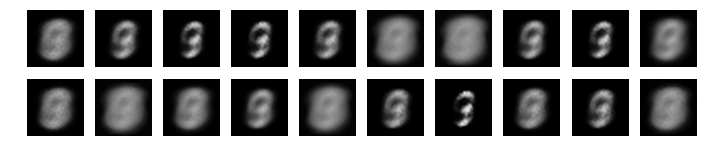

In [98]:
show_images(ae_model_d2['model'].generate_samples(20))

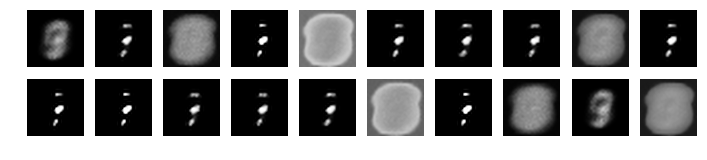

In [99]:
show_images(ae_model_d10['model'].generate_samples(20))

Визуализация латентного пространства (с точки зрения декодера)

In [100]:
def draw_manifold_ae(model):
    generator = lambda z: model.decode(Variable(torch.from_numpy(z).float())).view(28, 28).data.numpy()
    return draw_manifold(generator)

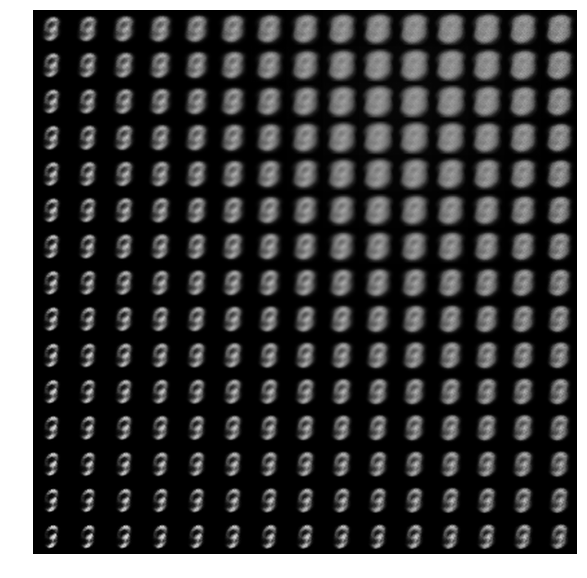

In [101]:
draw_manifold_ae(ae_model_d2['model'])

## Автокодировщик: теперь вариационный!

В качестве функции потерь используем бинарную кроссэнтропию.
Это означает, что мы предполагаем, что каждый пискель - бинарная случайная величина.
Генеративная сеть выдает вероятность каждого пикселя быть равным $1$.

In [ ]:
def log_likelihood(x_true, x_distr):
    """
    Вычисляет логарфм правдоподобия объектов x_true, который равен минус бинарной
    кроссэнтропии между эмприческим распределением на данные и индуцированным
    моделью распределением.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!
    Подсказка: делить логарифм правдоподобия на число компонент объекта не надо.

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    # ваш код здесь
    pass

In [ ]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Varibale - матрица размера n x k.
    Возвращаемое значение: Variable, вектор длины n.
    """
    # ваш код здесь
    pass

In [ ]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    p_mu, p_sigma = p_distr
    q_mu, q_sigma = q_distr
    # ваш код здесь
    pass

In [ ]:
class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        )
        # glorot uniform initialization
        lin_layers = [self.proposal_mu_head, self.proposal_sigma_head]
        lin_layers += [layer for layer in self.generative_network if isinstance(layer, nn.Linear)]
        lin_layers += [layer for layer in self.proposal_network if isinstance(layer, nn.Linear)]
        for lin in lin_layers:
            f_in, f_out = lin.weight.shape
            lin.weight.data.uniform_()
            lin.weight.data.mul_(2).sub_(1).mul_(torch.np.sqrt(6 / (f_in + f_out)))
            lin.bias.data.zero_()

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Подсказка: областью значений sigma должны быть положительные числа.
        Для этого при генерации sigma следует использовать exp или softplus
        в качестве последнего преобразования.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        pass
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        # ваш код здесь
        pass

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        # ваш код здесь
        pass

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        # ваш код здесь
        pass

    def batch_loss(self, batch):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Подсказка: вариационная нижняя оценка логарифма правдоподобия модели
        не должна зависеть от размера батча.
        Вход: batch, FloatTensor - матрица объектов размера n x D.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка логарифма
        правдоподобия по батчу.
        """
        # ваш код здесь
        pass

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        # ваш код здесь
        pass

### Оценки функции потерь

In [ ]:
def gaussian_log_pdf(distr, samples):
    """
    Функция вычисляет логарифм плотности вероятности в точке относительно соответствующего
    нормального распределения, заданного покомпонентно своими средним и среднеквадратичным отклонением.
    Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: samples, Variable - матрица размера (n * K) x d сэмплов в скрытом пространстве.
    Возвращаемое значение: Variable, вектор длины n * K, каждый элемент которого - логарифм
    плотности вероятности точки относительно соответствующего распределения. Точке с номером i
    соответствует распределение с номером i // K.
    """
    mu, sigma = distr
    K = samples.shape[0] // mu.shape[0]
    n = mu.shape[0]
    d = mu.shape[1]
    # ваш код здесь
    pass

In [ ]:
def compute_log_likelihood_monte_carlo(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Монте-Карло.
    Подсказка: оценка логарифма правдоподобия модели не должна зависеть от размера батча.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в VAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    pass

In [ ]:
def compute_log_likelihood_importance_sampling(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Importance Sampling.
    Подсказка: оценка логарифма правдоподобия модели не должна зависеть от размера батча.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    pass

### Обучение модели

In [ ]:
vae_tests = [
    {
        'name': 'MC',
        'func': lambda model:
                model_test_loss(lambda batch:
                                compute_log_likelihood_monte_carlo(batch, model, K=10),
                                max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model:
                model_test_loss(lambda batch:
                                compute_log_likelihood_importance_sampling(batch, model, K=10),
                                max_batches=20)
    }
]

In [ ]:
vae_model_d2 = train_model(VAE(2, 784), tests=vae_tests, num_epochs=50)

In [ ]:
vae_model_d10 = train_model(VAE(10, 784), tests=vae_tests, num_epochs=50)

### Оценка качества модели

Визуальная оценка генерируемых объектов

In [ ]:
show_images(vae_model_d2['model'].generate_samples(20))

In [ ]:
show_images(vae_model_d10['model'].generate_samples(20))

Визуализация латентного пространства (с точки зрения декодера)

In [ ]:
def draw_manifold_vae(model):
    generator = lambda z: model.generative_distr(Variable(torch.from_numpy(z).float())).view(28, 28).data.numpy()
    return draw_manifold(generator)

In [ ]:
draw_manifold_vae(vae_model_d2['model'])

Визуализация латетного пространства (с точки зрения энкодера)

In [ ]:
vae_encoder = lambda data, model: model.sample_latent(model.proposal_distr(Variable(data)))
draw_latent_space(test_data.data_tensor[::10], test_data.target_tensor[::10],
                  lambda data: vae_encoder(data, vae_model_d2['model']))

In [ ]:
vae_encoder_d10 = lambda data: TSNE().fit_transform(vae_encoder(data, vae_model_d10['model']).data.numpy())
draw_latent_space(test_data.data_tensor[::25], test_data.target_tensor[::25], vae_encoder_d10)

### Оценки логарифма правдоподобия на тестовых данных

In [ ]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('VAE, Monte-Carlo, $d = 2$', 'MC', vae_model_d2),
    ('VAE, Monte-Carlo, $d = 10$', 'MC', vae_model_d10),
    ('VAE, Importance Sampling, $d = 2$', 'IS', vae_model_d2),
    ('VAE, Importance Sampling, $d = 10$', 'IS', vae_model_d10),
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()
pass

In [ ]:
test_results = []
for K in [1, 5, 10, 50, 100, 500, 1000]:
    print('K =', K, flush=True)
    vae_tests_sampling = [
        {
            'name': 'D10MC',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_monte_carlo(batch, vae_model_d10['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D10IS',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_importance_sampling(batch, vae_model_d10['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D2MC',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_monte_carlo(batch, vae_model_d2['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D2IS',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_importance_sampling(batch, vae_model_d2['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        }
    ]
    cur_test_results = {'K': K}
    for test in vae_tests_sampling:
        cur_test_results[test['name']] = test['func']
    test_results.append(cur_test_results)

In [ ]:
plt.figure(figsize=(9, 6))
for label, name in [
    ('VAE, Monte-Carlo, $d = 2$', 'D2MC'),
    ('VAE, Importance Sampling, $d = 2$', 'D2IS'),
    ('VAE, Monte-Carlo, $d = 10$', 'D10MC'),
    ('VAE, Importance Sampling, $d = 10$', 'D10IS'),
]:
    data = [x[name] for x in test_results]
    x_labels = [x['K'] for x in test_results]
    plt.plot(x_labels, data, label=label)
plt.xlabel('Number of samples')
plt.xscale('log')
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы

Место для ваших выводов, наблюдений, гипотез.